### How do the perceived income moments correlate with other individual variables 

- this notebook runs regressions to inspects the covariants of individual perceived income moments
  - individual demogrpahics, level of household income, education, etc.
  - job-types, part-time vs full-time, selfemployment, etc. 
  - other expectations: probability of unemployment, other job-related expectations 
- it examiens both nominal and real income growth 


###  1. Loading and cleaning data

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

In [18]:
pd.options.display.float_format = '{:,.2f}'.format

In [19]:
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

In [20]:
## panel data 

#dataset.index = dataset[['date','userid']]

In [21]:
## variable list by catogrories 

vars_id = ['userid','date']

moms_nom = ['Q24_var']

moms_real = ['Q24_rvar']

vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36']  ## education (1-8 low to high, 9 other)

## these variables are only available for a sub sample 

vars_empexp = ['Q13new']  ## probability of unemployment 

vars_macroexp = ['Q6new',  ## stock market going up 
                 'Q4new']  ## UE goes up 

In [22]:
## subselect variables 

vars_all_reg_long = (vars_id+moms_nom + moms_real + vars_job + 
                     vars_demog + vars_demog_sub + 
                     vars_empexp + vars_macroexp)

## select dataset 

SCEM = dataset[vars_all_reg_long]
SCEM.describe(include='all')

,userid,date,Q24_var,Q24_rvar,Q10_1,Q10_2,Q12new,D6,Q32,Q33,Q36,Q13new,Q6new,Q4new
count,"79,064.00",79064,"47,501.00","44,639.00","79,064.00","79,064.00","51,520.00","67,901.00","11,630.00","11,656.00","11,658.00","45,921.00","78,182.00","78,767.00"
unique,nan,60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,2013-08-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,1769,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,nan,2013-06-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,nan,2018-05-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,"70,059,680.73",NaN,5.56,13.47,0.55,0.14,1.13,6.46,50.13,1.52,4.36,14.85,42.80,37.41
std,"20,176.72",NaN,11.12,19.82,0.50,0.34,0.34,2.72,16.58,0.50,1.55,20.41,23.08,22.77
min,"70,000,220.00",NaN,0.28,0.61,0.00,0.00,1.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00
25%,"70,044,346.00",NaN,0.36,1.67,0.00,0.00,1.00,4.00,38.00,1.00,3.00,1.00,25.00,20.00


### 2. Correlation pattern 

In [23]:
SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q13new':'UEprobInd',
                              'Q6new':'Stkprob',
                              'Q4new':'UEprobAgg',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

In [24]:
cleanup_nums = {'parttime': {0: 'no', 1: 'yes'},
                'fulltime': {0: 'no', 1: 'yes'},
                'selfemp':{1: 'no', 2: 'yes'},
                'gender':{1:'male',2:'female'}}
SCEM.replace(cleanup_nums,
            inplace = True)

In [25]:
## categorical variables 

vars_cat = ['HHinc','fulltime','parttime','selfemp','gender','userid','date']

for var in vars_cat:
    SCEM[var] = pd.Categorical(SCEM[var])

In [26]:
#pp = sns.pairplot(SCEM)

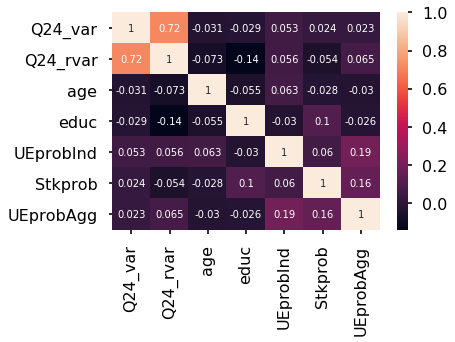

In [27]:
sns.heatmap(SCEM.corr(), 
            annot=True)

###  3. Histograms

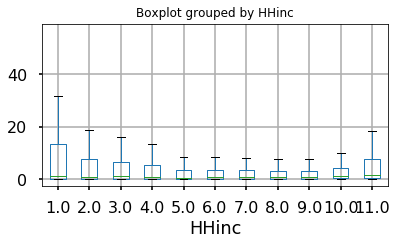

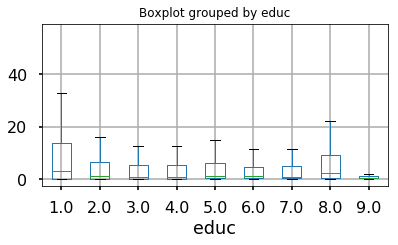

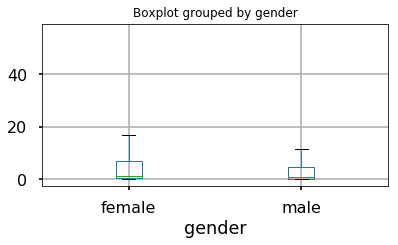

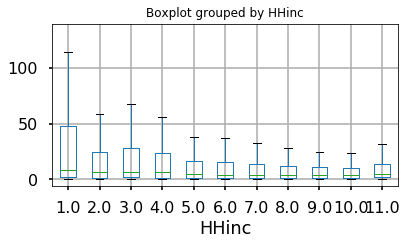

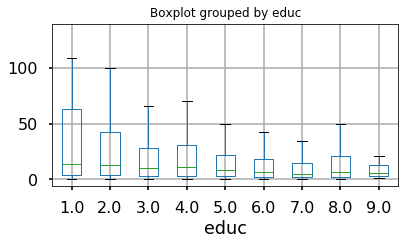

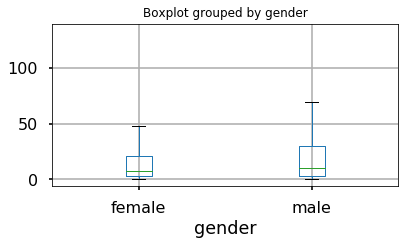

In [28]:
## by income group 

for mom in ['var','rvar']:
    for gp in ['HHinc','educ','gender']:
        plt.style.use('seaborn-poster')
        SCEM.boxplot(column=['Q24_'+str(mom)],
                     figsize = (6,3),
                     by = gp)
        plt.title('')
        plt.savefig('../Graphs/ind/boxplot'+str(mom)+'_'+str(gp)+'.jpg')

###  4. Regressions

In [29]:
## regressions try 

dep_list =  moms_nom + moms_real 
indep_list_ct = ['UEprobInd','UEprobInd','Stkprob']
indep_list_dc = ['HHinc','selfemp','fulltime']

rs_list = {}

for i,mom in enumerate(dep_list):
    ct_str = '+'.join([var for var in indep_list_ct])
    dc_str = '+C(HHinc)+C(parttime)+C(selfemp)'
    model = smf.ols(formula = str(mom)
                    +'~ ' + ct_str
                    + dc_str,
                    data = SCEM)
    rs_list[i] = model.fit()
    #print(rs_list[i].summary())
    
## combine different specifications 

rs_names = [rs_list[i] for i in range(len(rs_list))]
dfoutput = summary_col(rs_names,
                       float_format='%0.2f',
                       stars = True,
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput.title = 'perceived income risks'
#print(dfoutput)

In [30]:
## output tables 

beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}
\\begin{table}"""

endtex = "\end{table}\end{document}"


to_drop = ['Intercept']


In [31]:
## full-table 

rs_list = {}  ## list to store results 
nb_spc = 4  ## number of specifications 

for i,mom in enumerate(dep_list):
    ## model 1 
    model = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp)',
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    ## model 2
    ct_str = '+'.join([var for var in indep_list_ct])
    model2 = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp) + '
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+1] = model2.fit()
    
    ## model 3 
    model3 = smf.ols(formula = str(mom)
                    +'~ C(parttime) + C(selfemp) + C(HHinc) +'
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+2] = model3.fit()
    
    ## model 4 
    model4 = smf.ols(formula = str(mom)
                    +'~ C(gender)+ educ',
                    data = SCEM)
    rs_list[nb_spc*i+3] = model4.fit()
    
    
rs_names2 = [rs_list[i] for i in range(len(rs_list))]

dfoutput2 = summary_col(rs_names2,
                        float_format='%0.2f',
                        stars = True,
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput2.title = 'perceived income risks'
print(dfoutput2)

                                              perceived income risks
                   Q24_var I Q24_var II Q24_var III Q24_var IIII Q24_rvar I Q24_rvar II Q24_rvar III Q24_rvar IIII
------------------------------------------------------------------------------------------------------------------
C(HHinc)[T.10.0]                        -4.32***                                        -13.64***                 
                                        (0.54)                                          (1.08)                    
C(HHinc)[T.11.0]                        -2.23***                                        -11.70***                 
                                        (0.55)                                          (1.10)                    
C(HHinc)[T.2.0]                         -1.25**                                         -3.52***                  
                                        (0.59)                                          (1.18)                    
C(HHinc)[T.

In [32]:
## write to latex 
f = open('../Tables/latex/micro_reg.tex', 'w')
f.write(beginningtex)
tb = dfoutput2.tables[0].drop(index = to_drop)
tb_ltx = tb.to_latex()
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()